# Tutorial Warning Class

This tutorial shows how to use the `Warn` class to generate a warning, i.e., 2D map of coordinates with assigned warn
levels. Operations, their order, and their influence (filter sizes, gradual decrease of warn levels, and changing of
too small regions to surrounding) can be selected to generate the warning.
The functionality of the `Warn` class of reducing heterogeneity in a map can be applied to different inputs,
e.g., MeteoSwiss windstorm data (COSMO data), `TC`s, `Impact`s, etc.

In [1]:
import numpy as np
from scipy import sparse
import xarray as xr

from climada_petals.engine.warn import Warn
from climada.util.plot import geo_scatter_categorical
from climada.entity import ImpfTropCyclone, ImpactFuncSet
from climada.util.api_client import Client


plotting_parameters = dict()
plotting_parameters['cmap'] = 'Wistia'

# MeteoSwiss Storm Example

In [2]:
# Load MeteoSwiss storm example via client (COSMO2-E model)
client = Client()
dataset = client.get_dataset_info(name="cosmo2_2019121400")
path_files = client.download_dataset(dataset)[1][0]
ncdf = xr.open_dataset(path_files)
wind_matrix = ncdf.VMAX_10M.values[0, :, :]  # take one ensemble member of the numerical weather model COSMO

lon = ncdf.lon_1.values
lat = ncdf.lat_1.values
coord = np.vstack((lat.flatten(), lon.flatten())).transpose()

### Demonstrate Warning Generation

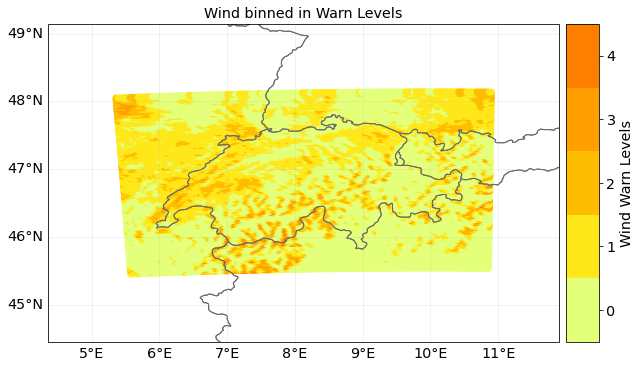

In [3]:
# Define warn levels and default operations for algorithm
warn_levels = np.array([0.0, 19.44, 25.0, 30.55, 38.88, 300.0])

# Define warning parameters, such that the data is only binned in warn levels (without operations)
filter_data_only_binning = Warn.WarnParameters(warn_levels, operations=[], gradual_decr=False, change_sm=False)
binned_map = Warn.from_map(wind_matrix, coord, filter_data_only_binning)
binned_map.plot_warning(var_name='Wind Warn Levels', title='Wind binned in Warn Levels', **plotting_parameters);

In [ ]:
# Define warning parameters, such that the data is generated with default parameters
filter_data_default = Warn.WarnParameters.wind_mch_default(warn_levels)
default_op_warning = Warn.from_map(wind_matrix, coord, filter_data_default)
default_op_warning.plot_warning(var_name='Wind Warn Levels', title='Warning generated by MeteoSwiss Defautls', **plotting_parameters);

When generating a warning, operations and their sizes can be selected by the users. This has an impact on how the warning
looks like. The different operations available can be seen below.

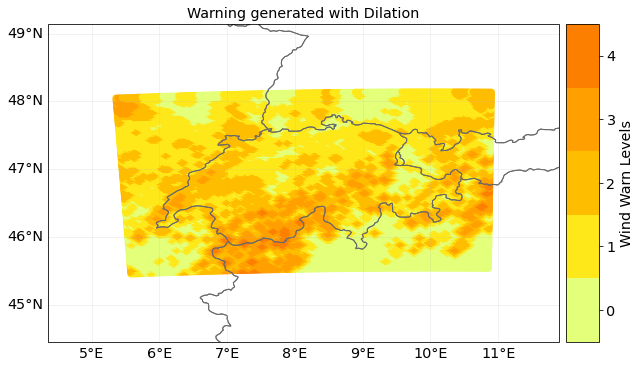

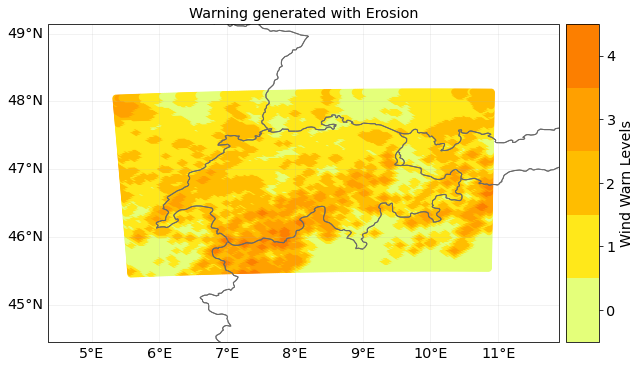

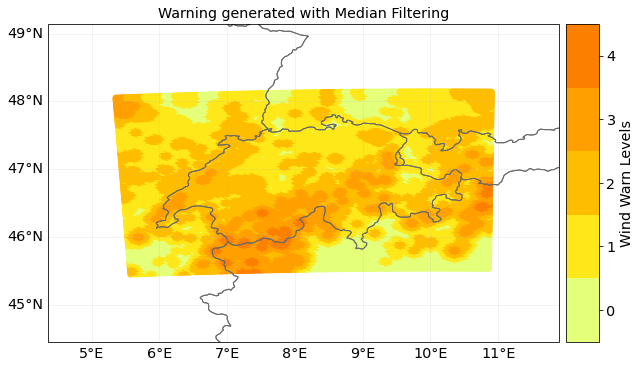

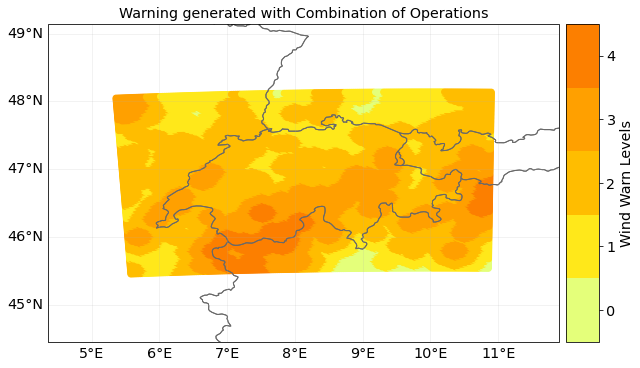

In [7]:
# Apply implemented operations separately to show their impact on how regions are formed during warning generation.
# Combinations of operations and their sizes can be changed by users to see their impact.

# only dilation
filter_data = Warn.WarnParameters(warn_levels, operations=[('dilation', 2)])
warn_dilation_only = Warn.from_map(wind_matrix, coord, filter_data)
warn_dilation_only.plot_warning(var_name='Wind Warn Levels', title='Warning generated with Dilation', **plotting_parameters);
# only erosion
filter_data = Warn.WarnParameters(warn_levels, operations=[('erosion', 2)])
warn_erosion_only = Warn.from_map(wind_matrix, coord, filter_data)
warn_erosion_only.plot_warning(var_name='Wind Warn Levels', title='Warning generated with Erosion', **plotting_parameters);
# only median filtering
filter_data = Warn.WarnParameters(warn_levels, operations=[('median_filtering', 3)])
warn_median_only = Warn.from_map(wind_matrix, coord, filter_data)
warn_median_only.plot_warning(var_name='Wind Warn Levels', title='Warning generated with Median Filtering', **plotting_parameters);
# first ersoion, then dilation, then median filtering
filter_data = Warn.WarnParameters(warn_levels, operations=[('erosion', 1), ('dilation', 3), ('median_filtering', 3)])
warn_combination = Warn.from_map(wind_matrix, coord, filter_data)
warn_combination.plot_warning(var_name='Wind Warn Levels', title='Warning generated with Combination of Operations', **plotting_parameters);

Next to selecting the operations, one can select whether the highest warn levels should be gradually decreased by its
neighboring regions (if True) to the lowest level (e.g., level 3, 2, 1, 0) or larger steps are allowed
(e.g., from level 5 directly to 2).

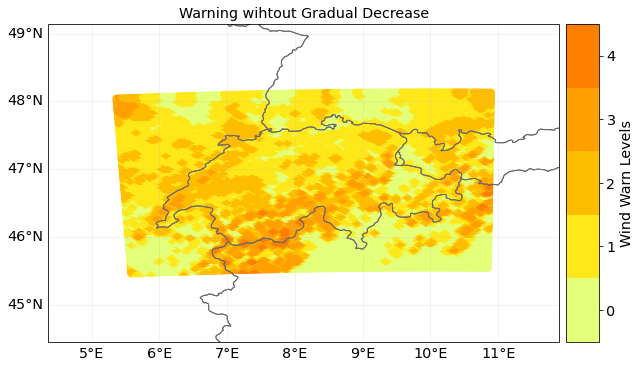

In [9]:
# Warning without gradual decrease of regions of higher level to lower levels to see difference to default parameters plot
filter_data = Warn.WarnParameters(warn_levels, gradual_decr=False)
warn_wo_grad = Warn.from_map(wind_matrix, coord, filter_data)
warn_wo_grad.plot_warning(var_name='Wind Warn Levels', title='Warning wihtout Gradual Decrease', **plotting_parameters);


Further, small regions of a warn level formed by the algorithm can be changed to the surrounding warn level.
Therefore, the parameter `change_sm` needs to be set to True.

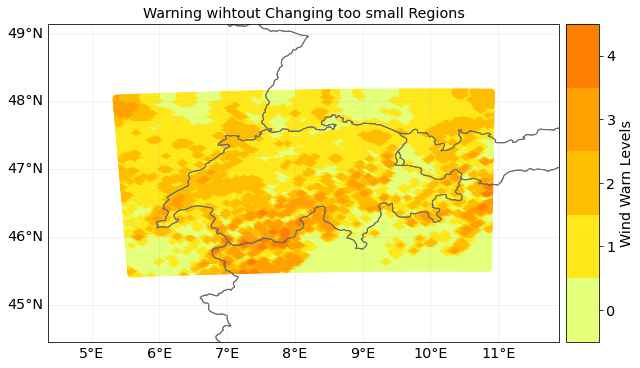

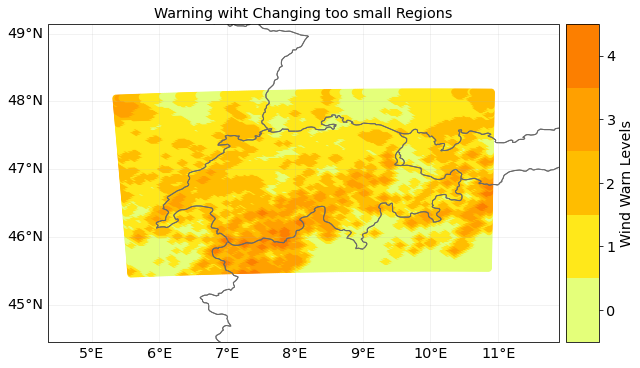

In [10]:
# Warning without and without change too small regions by setting levels newly.
filter_data = Warn.WarnParameters(warn_levels, gradual_decr=False)
warn_not_changed = Warn.from_map(wind_matrix, coord, filter_data)
warn_not_changed.plot_warning(var_name='Wind Warn Levels', title='Warning wihtout Changing too small Regions', **plotting_parameters);

filter_data = Warn.WarnParameters(warn_levels, change_sm=False)
warn_changed = Warn.from_map(wind_matrix, coord, filter_data)
warn_changed.plot_warning(var_name='Wind Warn Levels', title='Warning wiht Changing too small Regions', **plotting_parameters);

# Hazard Example - TC Haiti

In [11]:
tc_dataset_infos = client.list_dataset_infos(data_type='tropical_cyclone')
client.get_property_values(tc_dataset_infos, known_property_values = {'country_name':'Haiti'})

{'res_arcsec': ['150'],
 'climate_scenario': ['rcp26', 'rcp45', 'rcp85', 'historical', 'rcp60'],
 'ref_year': ['2040', '2060', '2080'],
 'nb_synth_tracks': ['50', '10'],
 'spatial_coverage': ['country'],
 'tracks_year_range': ['1980_2020'],
 'country_iso3alpha': ['HTI'],
 'country_name': ['Haiti'],
 'country_iso3num': ['332']}

2022-05-02 09:26:47,932 - climada.hazard.base - INFO - Reading /Users/robertblass/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_rcp45_HTI_2040/v1/tropical_cyclone_10synth_tracks_150arcsec_rcp45_HTI_2040.hdf5


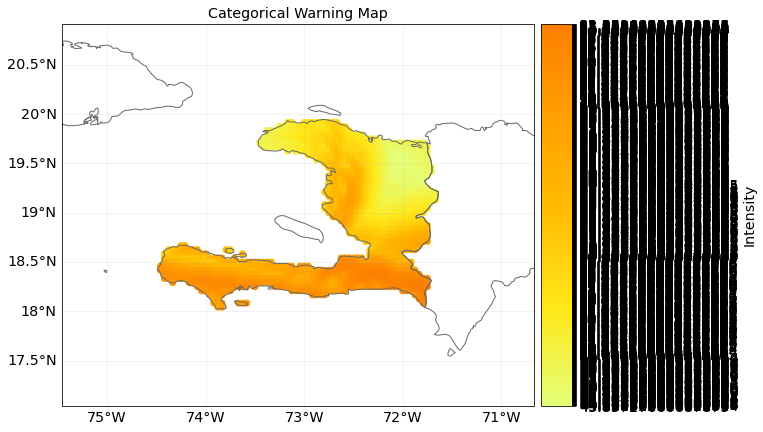

In [12]:
# Read hazard
tc_haiti = client.get_hazard('tropical_cyclone', properties={'country_name': 'Haiti', 'climate_scenario': 'rcp45', 'ref_year':'2040', 'nb_synth_tracks':'10'})
tc_haiti.intensity = sparse.csr_matrix(tc_haiti.intensity.max(axis=0))

lon = tc_haiti.centroids.lon
lat = tc_haiti.centroids.lat
coord_haiti = np.vstack((lat.flatten(), lon.flatten())).transpose()

geo_scatter_categorical(tc_haiti.intensity.todense().flatten(), coord_haiti, 'Intensity', 'Categorical Warning Map', **plotting_parameters);

In [13]:
# Function to pad country shape with zeros to form rectangle (as needed by algorithm)
def zeropadding(lat_, lon_, val):
    lat = np.round(lat_, decimals=12)
    lon = np.round(lon_, decimals=12)
    
    un_y = np.sort(np.unique(lat))
    un_x = np.sort(np.unique(lon))

    y = lat
    y0 = min(y)
    dy = abs(un_y[1] - un_y[0])
    x = lon
    x0 = min(x)
    dx = abs(un_x[1] - un_x[0])

    i = ((y - y0) / dy).astype(int)
    j = ((x - x0) / dx).astype(int)
    grid = np.zeros((len(np.unique(lat)), len(np.unique(lon))))
    grid[i, j] = val
    
    xx, yy = np.meshgrid(un_x, un_y)
    coord_ = np.vstack((yy.flatten(), xx.flatten())).transpose()
    
    return grid, coord_

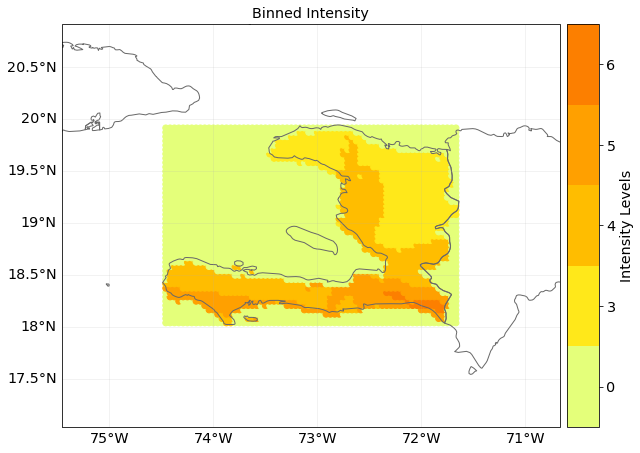

In [15]:
# Plot binned intensities
# warn Levels
warn_levels = [0, 20, 30, 40, 60, 70, 80, 1000]
grid, coord_haiti = zeropadding(tc_haiti.centroids.lat, tc_haiti.centroids.lon, tc_haiti.intensity.todense())

# no filtering operations applied - only binning as reference
filter_data_only_binning = Warn.WarnParameters(warn_levels, operations=[], gradual_decr=False, change_sm=False)
binned_only = Warn.from_map(grid, coord_haiti, filter_data_only_binning)
binned_only.plot_warning(var_name='Intensity Levels', title='Binned Intensity', **plotting_parameters);

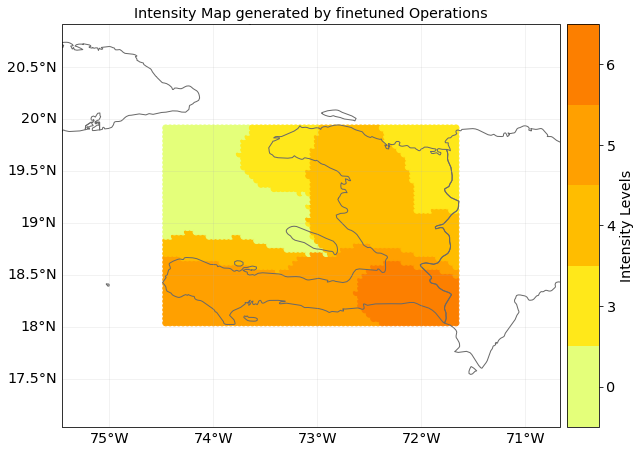

In [17]:
# Apply finetuned filtering operations without gradual decrease and changing too small regions
filter_data = Warn.WarnParameters(warn_levels, operations=[('erosion', 1), ('dilation', 1), ('median_filtering', 5)], gradual_decr=False, change_sm=False)
warn_def = Warn.from_map(grid, coord_haiti, filter_data)
warn_def.plot_warning(var_name='Intensity Levels', title='Intensity Map generated by finetuned Operations', **plotting_parameters);

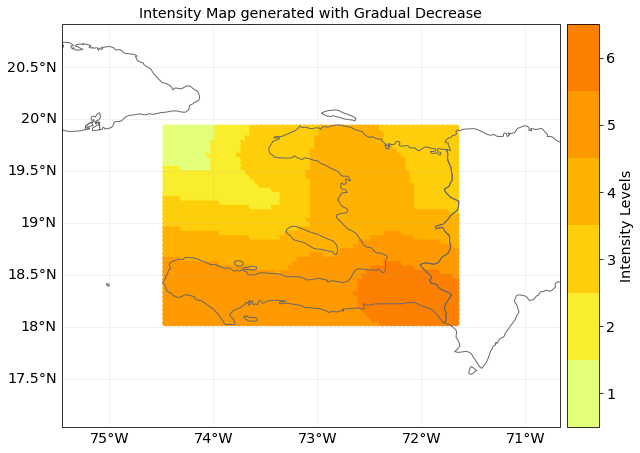

In [19]:
# Map generated with gradual decrease and changing too small regions to surrounding
filter_data = Warn.WarnParameters(warn_levels, operations=[('erosion', 1), ('dilation', 1), ('median_filtering', 5)], gradual_decr=True, change_sm=50)
warn_def = Warn.from_map(grid, coord_haiti, filter_data)
warn_def.plot_warning(var_name='Intensity Levels', title='Intensity Map generated with Gradual Decrease', **plotting_parameters);

# Impact Example - Value (USD) Haiti

In [20]:
# Example on impact data to show how any 2D map can be clustered and smoothed with this class
# get data
exp_haiti = client.get_litpop_default(country="Haiti")

2022-05-02 09:29:32,189 - climada.entity.exposures.base - INFO - Reading /Users/robertblass/climada/data/exposures/litpop/LitPop_150arcsec_HTI/v1/LitPop_150arcsec_HTI.hdf5


In [21]:
impf = ImpfTropCyclone().from_emanuel_usa()
impf_set = ImpactFuncSet()
impf_set.append(impf)

/Users/robertblass/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


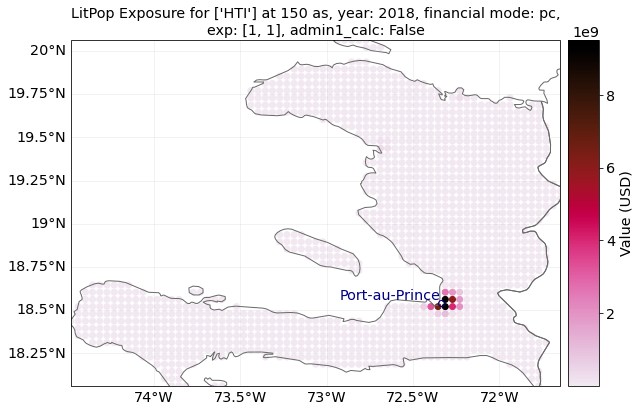

In [22]:
exp_haiti.plot_scatter();

In [23]:
lat, lon, values = exp_haiti.gdf.latitude.to_numpy(), exp_haiti.gdf.longitude.to_numpy(), exp_haiti.gdf.value.to_numpy()
grid, coord_impf = zeropadding(lat, lon, values)

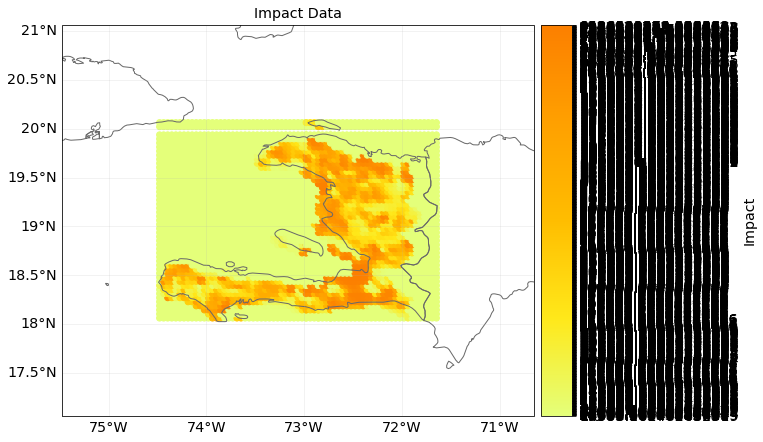

In [24]:
geo_scatter_categorical(grid.flatten(), coord_impf, 'Impact', 'Impact Data', **plotting_parameters);

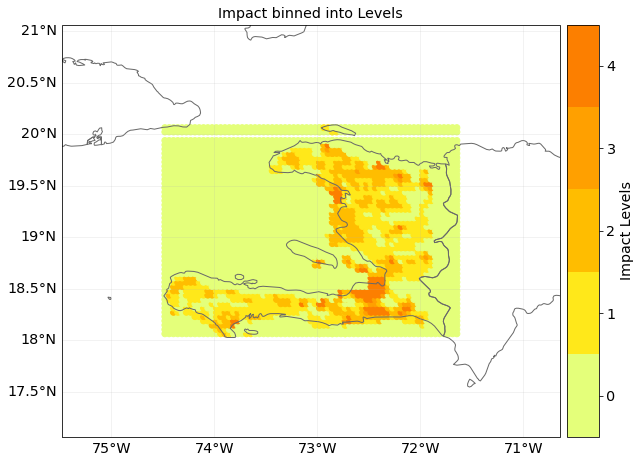

In [26]:
# Bin data into levels
levels = [0, 500000, 1000000, 6000000, 10000000, 10000000000]
filter_data = Warn.WarnParameters(levels, operations=[], gradual_decr=False, change_sm=False)
warn_def = Warn.from_map(grid, coord_impf, filter_data)
warn_def.plot_warning(var_name='Impact Levels', title='Impact binned into Levels', **plotting_parameters);

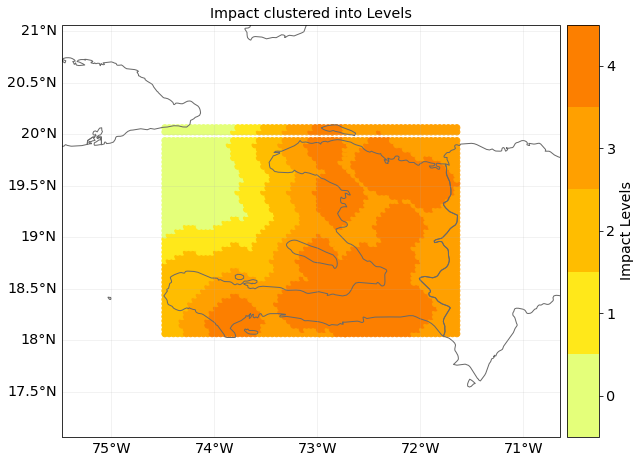

In [29]:
# Apply finetuned filtering operations with gradual decrease and changing too small regions
warn_levels = [0, 500000, 1000000, 6000000, 10000000,   10000000000]
filter_data = Warn.WarnParameters(warn_levels, operations=[('erosion', 1), ('dilation', 1), ('median_filtering', 3)], gradual_decr=True, change_sm=50)
warn_def = Warn.from_map(grid, coord_impf, filter_data)
warn_def.plot_warning(var_name='Impact Levels', title='Impact clustered into Levels', **plotting_parameters);